
# Nombre del Proyecto: Clasificador de Imágenes Piedra, Papel o Tijera con MLP

## Instalación del Dataset y Requerimientos

1. **Extnsiones en VS Code**: 
    - Descarga la extensión de Jupyter en VS code. 


2. **Requerimientos**:
    - Asegúrate de tener Python instalado (versión 3.11 o superior).
    - Instala las siguientes bibliotecas necesarias para el proyecto:
      ```bash
      pip install -r requirements.txt
      ```

3. **Ejecutar**:
    - Click en Run All

## Importación de dependencias

In [496]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

# Set random seed for reproducible results
tf.random.set_seed(22)
np.random.seed(22)

Python version: 3.11.0
Tensorflow version: 2.19.0
Keras version: 3.9.2


## Cargando el dataset

Se va a descargar el dataset Rock-Paper-Scissors de la colección TensorFlow Datasets. Para eso se descargó el módulo tensorflow_datasets.

tensorflow_datasets define una colección de datasets listos para usar con TensorFlow.

Cada conjunto de datos se define como un tfds.core.DatasetBuilder, que encapsula la lógica para descargar el conjunto de datos y construir un pipeline de entrada, además de contener la documentación del conjunto de datos (versión, divisiones, número de ejemplos, etc.).

In [497]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [498]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



In [499]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='tmp\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-data

In [500]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [501]:
# Función para convertir label ID a cadenas de etiquetas.
get_label_name = dataset_info.features['label'].int2str
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


## Explorando el dataset

In [502]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

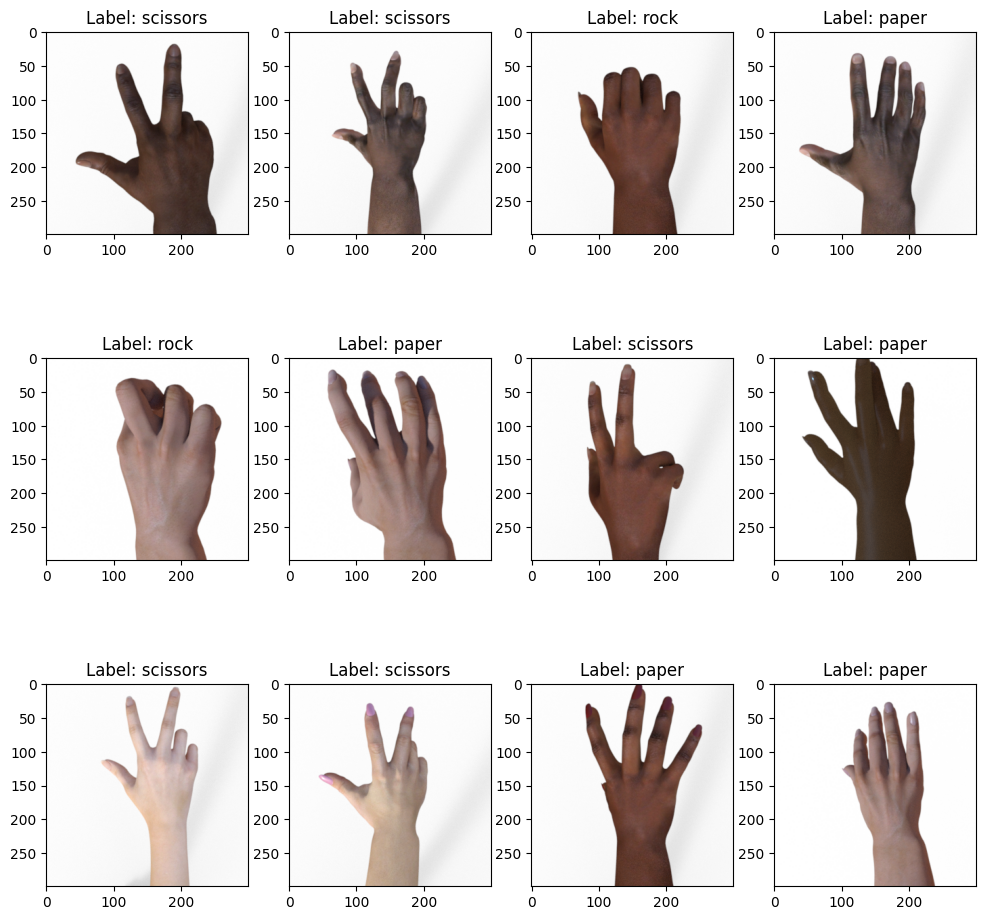

In [503]:
# Explorando las imagenes del dataset. 
preview_dataset(dataset_train_raw)

## Generando el dataset de landmarks
La idea es entrenar al modelo en base a las distancias y posiciones relativas entre los landmarks de las manos

In [504]:
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)

def image_to_landmarks_list(image: tf.Tensor | np.ndarray):
    # Convert the image to a numpy array
    if not isinstance(image, np.ndarray):
        image_np = image.numpy()
    else:
        image_np = image
    # Process the image with MediaPipe Hands
    results = hands.process(image_np)
    if results.multi_hand_landmarks:
        # Extract the first hand's landmarks
        hand_landmarks = results.multi_hand_landmarks[0]
        # Convert landmarks to a list of (x, y, z) tuples
        landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
        # Flatten the list of tuples
        landmarks = [coord for landmark in landmarks for coord in landmark]
        return landmarks
    else:
        return None

def extract_landmarks_from_dataset(dataset):
    landmarks_list = []
    for image, label in dataset:
        landmarks = image_to_landmarks_list(image)
        if landmarks is None:
            continue
        
        landmarks_list.append((landmarks, label))
    # Convert landmarks and labels to numpy arrays for compatibility
    landmarks_array = np.array([landmarks for landmarks, label in landmarks_list], dtype=np.float32)
    labels_array = np.array([label.numpy() for landmarks, label in landmarks_list], dtype=np.int64)
    
    return tf.data.Dataset.from_tensor_slices((landmarks_array, labels_array))

In [ ]:
# Convert the raw datasets to landmarks datasets
landmarks_train_dataset = extract_landmarks_from_dataset(dataset_train_raw)
landmarks_test_dataset = extract_landmarks_from_dataset(dataset_test_raw)

NUM_TRAIN_EXAMPLES = len(landmarks_train_dataset)
NUM_TEST_EXAMPLES = len(landmarks_test_dataset)

print("Landmarks train dataset size:", NUM_TRAIN_EXAMPLES)
print("Landmarks test dataset size:", NUM_TEST_EXAMPLES)

for landmarks, label in landmarks_train_dataset.take(1):
    print("Landmarks:", landmarks.numpy())
    print("Label:", label.numpy())
    print("Label Name:", get_label_name(label.numpy()))
    print()

Landmarks train dataset size: 2411
Landmarks test dataset size: 369
Landmarks: [ 6.8167770e-01  8.4967631e-01  1.8009488e-06  5.0319248e-01
  7.7246845e-01  2.9636778e-02  3.8944510e-01  6.9528306e-01
 -6.3604582e-03  2.7978975e-01  6.5995479e-01 -2.7736438e-02
  1.7210045e-01  6.3019550e-01 -4.3311838e-02  5.0136852e-01
  5.2587700e-01 -1.7401506e-01  4.3176162e-01  3.6629954e-01
 -1.8974699e-01  3.9001644e-01  2.6205713e-01 -1.9830045e-01
  3.6763376e-01  1.8108350e-01 -2.0962986e-01  5.9961140e-01
  5.1442981e-01 -1.3758570e-01  6.1223280e-01  3.1454688e-01
 -1.5149420e-01  6.1450768e-01  1.9491860e-01 -1.4116605e-01
  6.2225586e-01  1.0148358e-01 -1.4591493e-01  6.8514323e-01
  5.2538836e-01 -7.1519874e-02  6.5574163e-01  4.2548826e-01
  4.7680464e-02  6.3169301e-01  5.0019675e-01  1.5283406e-01
  6.3015467e-01  5.5452228e-01  1.9062963e-01  7.5229168e-01
  5.2690172e-01 -7.0228721e-03  7.3038697e-01  4.6298939e-01
  1.1558351e-01  7.0742297e-01  5.2192813e-01  1.8979155e-01
  7.06

## Barajado de datos y procesamiento por lotes 

No se quiere que el modelo aprenda algo del orden o la agrupación de las imágenes en el conjunto de datos. Para evitarlo, se va a barajear los ejemplos de entrenamiento. También se va a dividr el conjunto de entrenamiento por lotes para hacer el proceso de entrenamiento más rápido y que consuma menos memoria. 

In [522]:
BATCH_SIZE = 32

train_shuffled = (
    landmarks_train_dataset.shuffle(buffer_size=landmarks_train_dataset.cardinality())
    .batch(batch_size=BATCH_SIZE)
    .prefetch(
        # Prefetch permitirá que el pipeline de entrada obtenga lotes de forma asincrónica mientras su modelo está entrenando.
        buffer_size=tf.data.experimental.AUTOTUNE
    )
)

test_shuffled = landmarks_test_dataset.batch(BATCH_SIZE)

## Creando el modelo 

In [523]:
model = tf.keras.models.Sequential(name="rock_paper_scissors_mlp")

# Aplanar los resultados para alimentar las capas densas.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))

# Capas ocultas
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))

# Capa de salida.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

c:\Users\rober\Desktop\universidad\proy1_ia_modelo\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [524]:
model.summary()

Model: "rock_paper_scissors_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_23 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compilando el modelo 

In [525]:
# Se usa el optimizador Adam para la optimización del modelo.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [526]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 75
validation_steps: 11


In [527]:
# Preparando los callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras'
)

# Parada temprana
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [528]:
# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

training_history = model.fit(
    x=train_shuffled,
    validation_data=test_shuffled,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7189 - loss: 0.7645 - val_accuracy: 0.6761 - val_loss: 1.2761
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9091 - loss: 0.1703 - val_accuracy: 0.6705 - val_loss: 1.3335
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9339 - loss: 0.2313 - val_accuracy: 0.6818 - val_loss: 1.4951
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1017 - val_accuracy: 0.6761 - val_loss: 1.5767
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9588 - loss: 0.1435 - val_accuracy: 0.6818 - val_loss: 1.5556
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0524 - val_accuracy: 0.6818 - val_loss: 1.5646
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9610 - loss: 0.1146 - val_accuracy: 0.6960 - val_loss: 1.3706
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.6960 - val_l

In [529]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

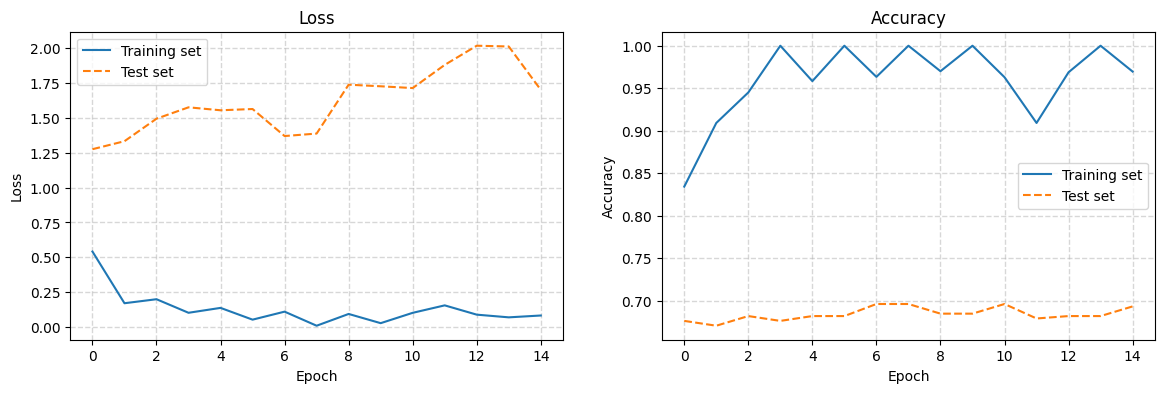

In [530]:
render_training_history(training_history)

## Evaluando la precisión del modelo 

In [531]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=landmarks_train_dataset.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=landmarks_test_dataset.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9912 - loss: 0.0264
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7001 - loss: 1.6066


In [532]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.02527826651930809
Training accuracy:  0.9921194314956665


Test loss:  1.7561814785003662
Test accuracy:  0.6910569071769714


## Guardando el modelo 

In [533]:
model_name = 'rock_paper_scissors_mlp.h5'
model.save(model_name, save_format='h5')

## Probando el modelo con imagenes externas

In [534]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('rock_paper_scissors_mlp.h5')

In [535]:
from PIL import Image

def preprocess_image(image_path):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Convertir la imagen a un array de NumPy
    img_array = np.array(img)
    return image_to_landmarks_list(img_array)

In [536]:
# Ruta de la imagen a probar
image_path = 'tijera.png'

# Preprocesar la imagen
input_image = preprocess_image(image_path)

# Convertir la lista de landmarks a un array de NumPy y agregar una dimensión de lote
input_image = np.array(input_image, dtype=np.float32)
input_image = np.expand_dims(input_image, axis=0)

# Hacer la predicción
predictions = model.predict(input_image)

print('Predicciones:', predictions)

# Obtener la clase con mayor probabilidad
predicted_class = np.argmax(predictions, axis=1)[0]

print(f'Predicción: Clase {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicciones: [[7.7042246e-04 1.3373878e-04 9.9909580e-01]]
Predicción: Clase 2


In [537]:
# Convertir la clase predicha a su etiqueta
label_name = get_label_name(predicted_class)
print(f'La imagen pertenece a la clase: {label_name}')

La imagen pertenece a la clase: scissors
